In [1]:
import gym
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import linalg
from copy import deepcopy
import time

/home/martin/anaconda3/envs/pysc2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
num_frames = 2
max_steps = 2000
num_games = 200

lr = 2e-5
training_epochs = 1
D_hid1 = 150
D_hid2 = 60
red_Din = 160
Din = 128
Dout = 6

In [3]:
def int2onehot(n, max_n):
    res = np.zeros(max_n)
    res[n] = 1.
    return res

In [4]:
def dim_reduce(a, V, keep_dim):
    res = np.zeros([keep_dim])
    for i in range(keep_dim):
        res[i] = np.matmul(a, V[i])
    return res

In [5]:
def red_train_agent2(training_epochs,red_games, commulative_rewards_np):
    merged_summary = tf.summary.merge_all()
    mx = commulative_rewards_np.max()
    mean = commulative_rewards_np.mean()
    amplitude = commulative_rewards_np.max() - commulative_rewards_np.min()
    step = 1
    for red_game, reward in zip(red_games, commulative_rewards_np):
        step += 1
        actions = np.array([_[1] for _ in red_game])
        observations = np.array([_[0] for _ in red_game])
        l = len(observations)
        for n in range(training_epochs):
            grads_buff = sess.run(red_grads, feed_dict={red_x:observations.reshape([l, red_Din]).astype(dtype=np.float32),
                                                   red_y_:actions.reshape([l, Dout]).astype(dtype=np.float32)})
            c = (reward - mean) / mean
            sess.run(red_apply_grads, \
                feed_dict={red_grad1_ph:(c * grads_buff[0][0]), \
                                red_grad2_ph:(c * grads_buff[1][0]), \
                               red_grad3_ph:(c * grads_buff[2][0]), \
                               red_grad4_ph:(c * grads_buff[3][0])})

In [6]:
def play_random(num_games, max_steps, render):
    games = deque()
    env = gym.make("DemonAttack-ram-v4")
    commulative_rewards = deque()
    for i in range(num_games):
        #comp_observation = deque(maxlen = 3)
        observation = np.array(env.reset())
        comp_observation = deepcopy(observation) 
        comp_observations = deque()
        actions = deque()
        current_game = deque()
        commulative_reward = 0
        for j in range(max_steps):
            if render:
                env.render()            
            old_observation = observation
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            if len(comp_observation) == num_frames * 128:
                comp_observations.append(deepcopy(comp_observation))
            comp_observation = np.hstack((comp_observation, deepcopy(old_observation)))[-num_frames * 128:]
            commulative_reward += reward
            if(len(comp_observation) == num_frames * 128):
                current_game.append((comp_observation, int2onehot(action, env.action_space.n), reward))
                actions.append(int2onehot(action, env.action_space.n))
                comp_observations.append(comp_observation)
            if done:
                break;
        games.append(current_game)
        commulative_rewards.append(commulative_reward)
    #env.close()
    #del env
    return games, commulative_rewards

In [7]:
def red_play(num_games, max_steps, render, V):
    games = deque()
    actions = [ _ for _ in range(0, 6)]
    env = gym.make("DemonAttack-ram-v4")
    commulative_rewards = deque()
    for i in range(num_games):
        observation = env.reset()
        comp_observation = deepcopy(observation)
        current_game = deque()
        commulative_reward = 0
        for j in range(max_steps):
            if render:
                env.render()
            if len(comp_observation) == num_frames * 128:
                #print "red_play: random_choice(probabilities)", len(comp_observation)
                red_observation = dim_reduce(comp_observation, V, red_Din)
                probabilities = sess.run(red_y, \
                                     feed_dict={red_x:red_observation.reshape([1, \
                                        len(red_observation)]).astype(dtype=np.float32)})
                action = np.random.choice(a=actions, p=probabilities[0])
                observation, reward, done, info = env.step(action)
                current_game.append((red_observation, int2onehot(action, env.action_space.n), reward))
            else:
                #print "red_play: action_space.sample:", len(comp_observation)
                action = env.action_space.sample()
                observation, reward, done, info = env.step(action)
            commulative_reward += reward
            
            comp_observation = np.hstack((comp_observation, observation))[-num_frames * 128:]
            if done:
                break;
        games.append(current_game)
        commulative_rewards.append(commulative_reward)
    #env.close()
    #del env
    return games, commulative_rewards

In [8]:
games, commulative_rewards = play_random(num_games=num_games, max_steps=2000, render=False)
commulative_rewards_np = np.array(commulative_rewards)

161.525


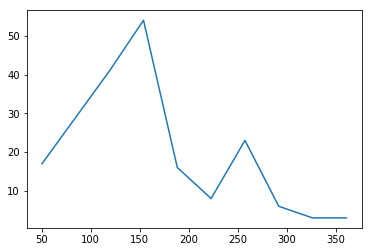

In [9]:
rewards_np = np.array( [_ for _ in commulative_rewards], dtype=np.float )
print (rewards_np.mean())
h = np.histogram(rewards_np)
plt.plot(h[1][:len(h[1]) - 1] + 10.5, h[0])
plt.show()

In [10]:
game = games[commulative_rewards_np.argmax()]
commulative_reward = commulative_rewards[commulative_rewards_np.argmax()]
print (game[0], commulative_reward)
print (game[0][0], game[0][1], game[0][2])

(array([  1, 171,   0, 205,   0, 234,   0,   0,   0,  17,   0,   0,  32,
         0,   0, 216, 216,   0,   0,  73, 152,  27, 200,   1,  42,   0,
         4,   1,  64,   0,   0,   5,   0,   0,   0,   5,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  34,  16,  16, 182,  15,   0,
         1,   0,   0,   0,   0,   0,   0,   3,   0,  62,   1,  51,  40,
        30,  40,  30,  76, 134, 106,  76,   0,   0,   0, 128,   0, 182,
        31,   0,   0, 255,  44,  86,  76, 220,  66,  14,   8,  64,   1,
       192,   0, 100,  31, 110,  31, 120,  31, 130,  31, 140,  31, 128,
        31, 255,   1, 128,   4,   0,   3,   0,   1,   0,   0,   0,   0,
         0,   0, 140,   0, 188,   0,   0,  36,  28, 135,  19,   1, 171,
         0, 205,   0, 234,   0,   0,   0,  17,   0,   0,  32,   0,   0,
       216, 216,   0,   0,  73, 152,  27, 200,   1,  42,   0,   4,   1,
        64,   0,   0,   5,   0,   0,   0,   5,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  34,  16,  16, 182,  15,   0,  

In [11]:
observations = np.array([_[0] for _ in game], dtype=np.float)

In [12]:
U, s, V = linalg.svd(observations[1:], full_matrices=True, compute_uv=True, overwrite_a=False, check_finite=True, lapack_driver='gesdd')

In [13]:
print (s)

[6.29752012e+04 8.21350443e+03 6.89811334e+03 6.43547947e+03
 6.06243759e+03 5.79733290e+03 5.32771325e+03 5.07933231e+03
 4.83374456e+03 4.73117471e+03 4.59962142e+03 4.37553929e+03
 4.16501194e+03 4.14585195e+03 3.96948335e+03 3.81257316e+03
 3.73318125e+03 3.58791983e+03 3.50783166e+03 3.48373172e+03
 3.31194964e+03 3.15543997e+03 3.06659435e+03 3.03264459e+03
 2.96595731e+03 2.89087538e+03 2.84226528e+03 2.81627696e+03
 2.77753554e+03 2.74405407e+03 2.71958359e+03 2.66204627e+03
 2.63253653e+03 2.60605687e+03 2.58624982e+03 2.55626274e+03
 2.49185553e+03 2.45846257e+03 2.40390399e+03 2.37023595e+03
 2.33280422e+03 2.27413471e+03 2.24876136e+03 2.14943849e+03
 2.11035987e+03 2.05675012e+03 2.02343200e+03 1.97241456e+03
 1.89102641e+03 1.87097529e+03 1.83462536e+03 1.56492138e+03
 1.47523557e+03 1.46439774e+03 1.41034862e+03 1.37927674e+03
 1.35702424e+03 1.24209153e+03 1.21461525e+03 1.15980259e+03
 1.15624420e+03 1.10323815e+03 1.09401000e+03 1.03591542e+03
 9.62774007e+02 9.135641

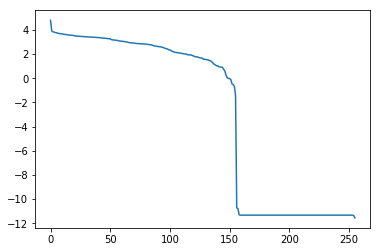

In [14]:
plt.plot(np.log10(s))
plt.show()

In [15]:
sess = tf.Session()

In [16]:
red_x = tf.placeholder(tf.float32, [None, red_Din], name="red_x")

red_grad1_ph = tf.placeholder(tf.float32, name="red_grad1_ph")
red_grad2_ph = tf.placeholder(tf.float32, name="red_grad2_ph")
red_grad3_ph = tf.placeholder(tf.float32, name="red_grad3_ph")
red_grad4_ph = tf.placeholder(tf.float32, name="red_grad4_ph")


red_W1 = tf.Variable(tf.random_normal([red_Din, D_hid1], stddev=0.0001), name="red_W1")
red_b1 = tf.Variable(tf.random_normal([D_hid1], stddev=0.0001), name="red_b1") 

red_W = tf.Variable(tf.random_normal([D_hid1, Dout], stddev=0.0001), name="red_W")
red_b = tf.Variable(tf.random_normal([Dout], stddev=0.0001), name="red_b")

red_H = tf.nn.relu(tf.matmul(red_x, red_W1) + red_b1)
red_y = tf.nn.softmax(tf.matmul(red_H, red_W) + red_b)
#red_y = tf.nn.softmax(tf.matmul(red_x, red_W) + red_b, name = "red_y")
red_y_ = tf.placeholder(tf.float32, [None, Dout], name="red_y_")

In [17]:
#red_cross_entropy = tf.reduce_mean(-tf.reduce_sum(red_y_ * tf.log(red_y), reduction_indices=[1]))
red_square_loss = tf.reduce_mean(tf.pow(red_y_ - red_y, 2))

In [18]:
red_adam = tf.train.AdamOptimizer(learning_rate=lr)

#tvars = tf.trainable_variables()
red_tvars = [red_W, red_b, red_W1, red_b1]

red_grads = red_adam.compute_gradients(loss=red_square_loss, var_list=red_tvars)
red_apply_grads = red_adam.apply_gradients(zip([red_grad1_ph, red_grad2_ph, red_grad3_ph, red_grad4_ph],red_tvars))

In [19]:
sess.run(tf.global_variables_initializer())

In [20]:
rewards = np.ndarray([0], dtype=np.float32)

Iteration: 1 / 1


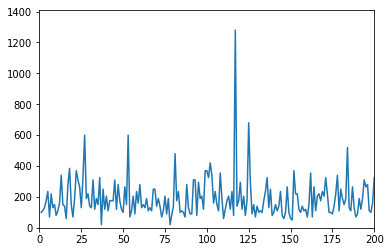

total_num_games=200 average=190.125 moving_average=190.125 time_mins=6
Iteration: 2 / 1


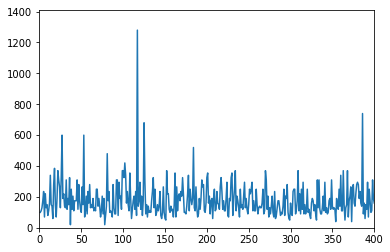

total_num_games=400 average=180.025 moving_average=169.925 time_mins=6
Iteration: 3 / 1


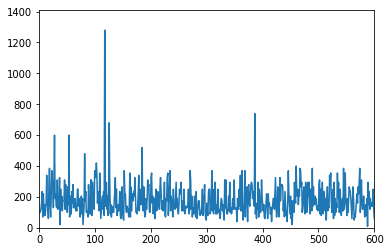

total_num_games=600 average=179.333 moving_average=177.950 time_mins=6
Iteration: 4 / 1


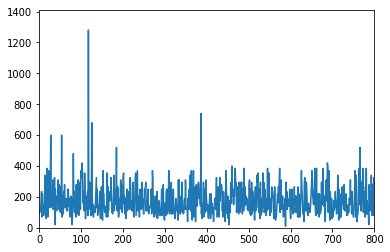

total_num_games=800 average=178.656 moving_average=176.625 time_mins=6
Iteration: 5 / 1


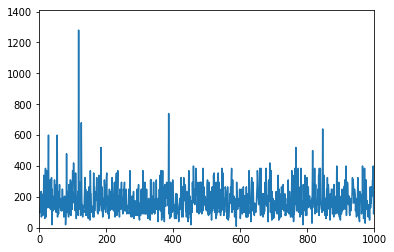

total_num_games=1000 average=179.940 moving_average=185.075 time_mins=6
Iteration: 6 / 1


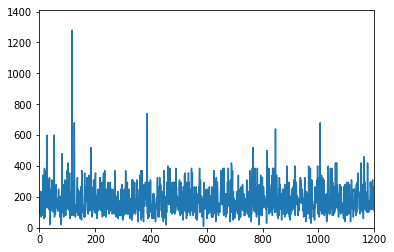

total_num_games=1200 average=181.079 moving_average=186.775 time_mins=6
Iteration: 7 / 1


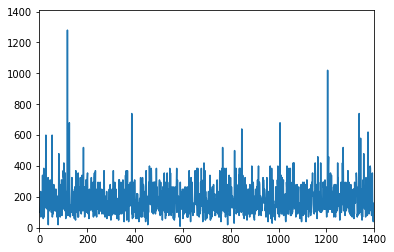

total_num_games=1400 average=183.125 moving_average=195.400 time_mins=6
Iteration: 8 / 1


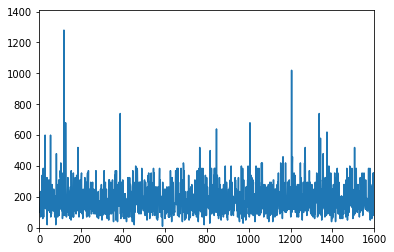

total_num_games=1600 average=184.191 moving_average=191.650 time_mins=7
Iteration: 9 / 1


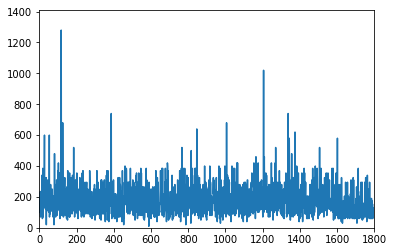

total_num_games=1800 average=177.822 moving_average=126.875 time_mins=9
Iteration: 10 / 1


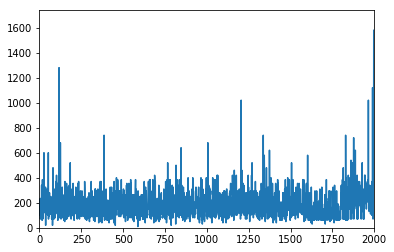

total_num_games=2000 average=186.440 moving_average=264.000 time_mins=8
Iteration: 11 / 1


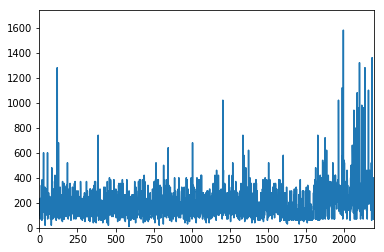

total_num_games=2200 average=196.950 moving_average=302.050 time_mins=8
Iteration: 12 / 1


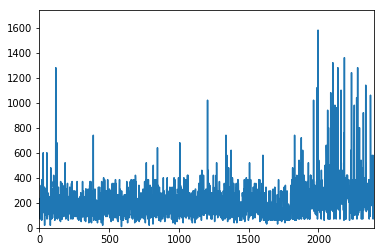

total_num_games=2400 average=205.396 moving_average=298.300 time_mins=8
Iteration: 13 / 1


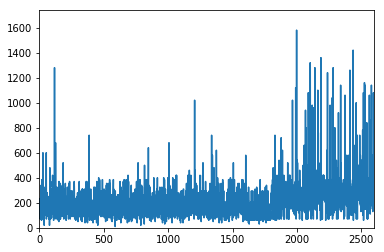

total_num_games=2600 average=214.852 moving_average=328.325 time_mins=8
Iteration: 14 / 1


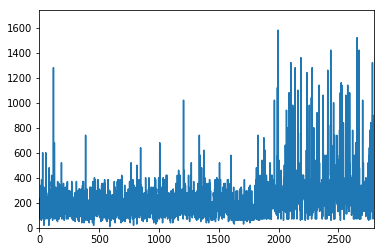

total_num_games=2800 average=220.848 moving_average=298.800 time_mins=8
Iteration: 15 / 1


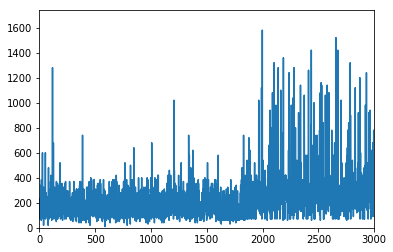

total_num_games=3000 average=227.300 moving_average=317.625 time_mins=8
Iteration: 16 / 1


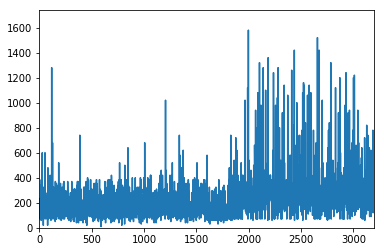

total_num_games=3200 average=232.947 moving_average=317.650 time_mins=8
Iteration: 17 / 1


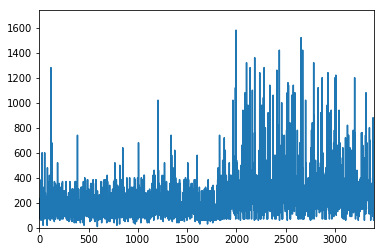

total_num_games=3400 average=236.499 moving_average=293.325 time_mins=8
Iteration: 18 / 1


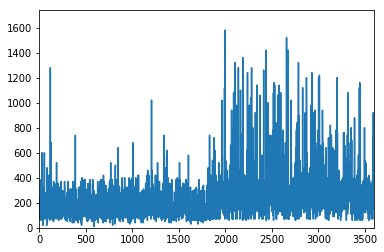

total_num_games=3600 average=238.787 moving_average=277.700 time_mins=8
Iteration: 19 / 1


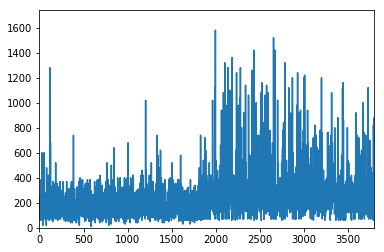

total_num_games=3800 average=242.271 moving_average=304.975 time_mins=8
Iteration: 20 / 1


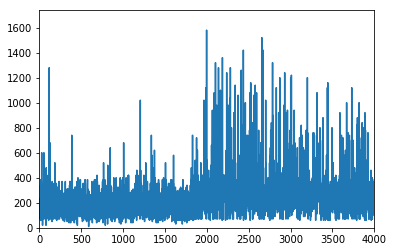

total_num_games=4000 average=244.031 moving_average=277.475 time_mins=8
Iteration: 21 / 1


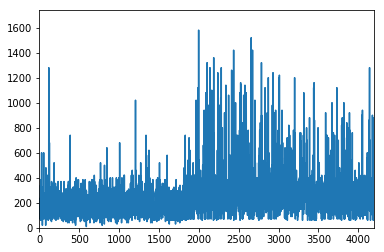

total_num_games=4200 average=246.198 moving_average=289.525 time_mins=7
Iteration: 22 / 1


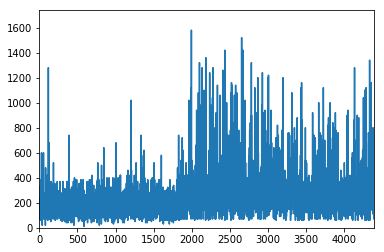

total_num_games=4400 average=249.006 moving_average=307.975 time_mins=8
Iteration: 23 / 1


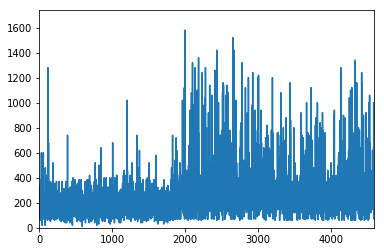

total_num_games=4600 average=250.950 moving_average=293.725 time_mins=8
Iteration: 24 / 1


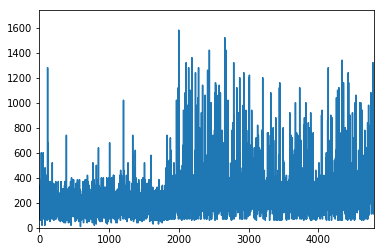

total_num_games=4800 average=253.643 moving_average=315.575 time_mins=8
Iteration: 25 / 1


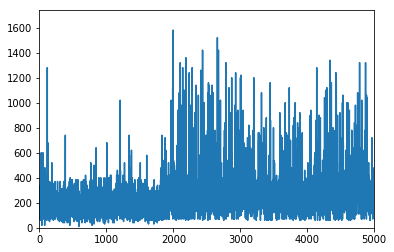

total_num_games=5000 average=255.487 moving_average=299.750 time_mins=8
Iteration: 26 / 1


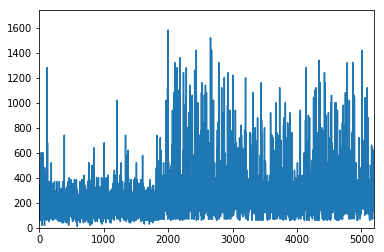

total_num_games=5200 average=257.401 moving_average=305.250 time_mins=8
Iteration: 27 / 1


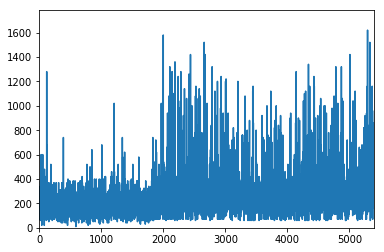

total_num_games=5400 average=260.746 moving_average=347.725 time_mins=8
Iteration: 28 / 1


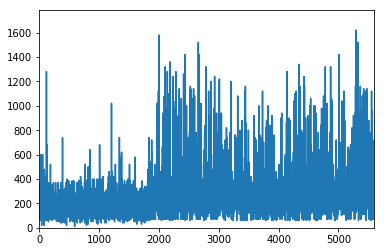

total_num_games=5600 average=263.778 moving_average=345.625 time_mins=8
Iteration: 29 / 1


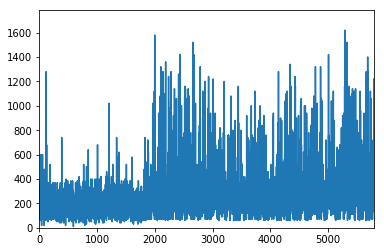

total_num_games=5800 average=266.049 moving_average=329.650 time_mins=8
Iteration: 30 / 1


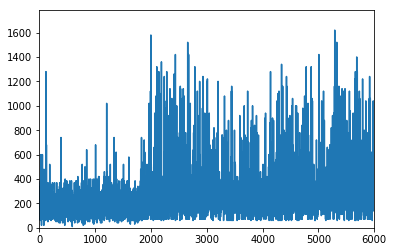

total_num_games=6000 average=268.207 moving_average=330.800 time_mins=8
Iteration: 31 / 1


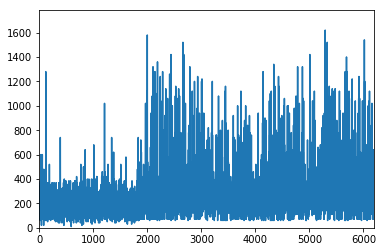

total_num_games=6200 average=269.993 moving_average=323.550 time_mins=8
Iteration: 32 / 1


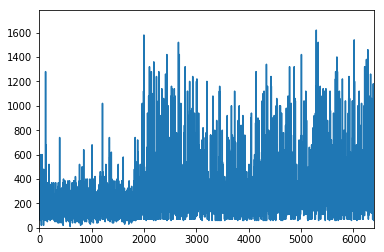

total_num_games=6400 average=272.705 moving_average=356.800 time_mins=8
Iteration: 33 / 1


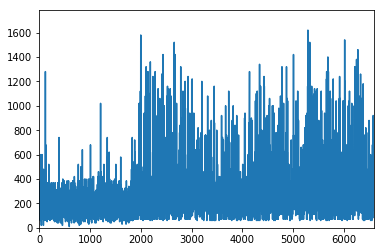

total_num_games=6600 average=273.690 moving_average=305.200 time_mins=8
Iteration: 34 / 1


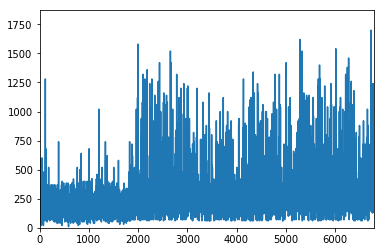

total_num_games=6800 average=275.170 moving_average=324.000 time_mins=8
Iteration: 35 / 1


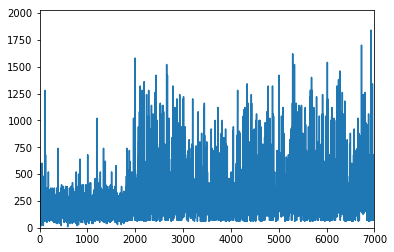

total_num_games=7000 average=276.467 moving_average=320.575 time_mins=8
Iteration: 36 / 1


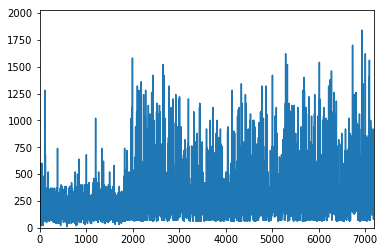

total_num_games=7200 average=277.791 moving_average=324.125 time_mins=8
Iteration: 37 / 1


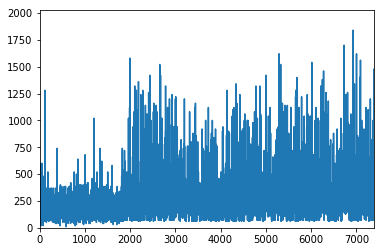

total_num_games=7400 average=277.928 moving_average=282.850 time_mins=8
Iteration: 38 / 1


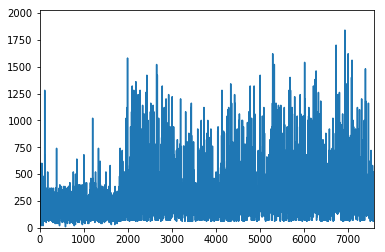

total_num_games=7600 average=277.253 moving_average=252.275 time_mins=8
Iteration: 39 / 1


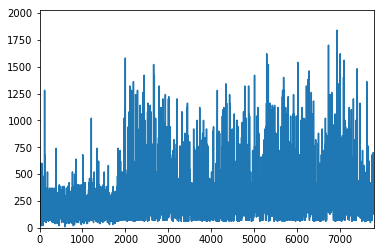

total_num_games=7800 average=276.621 moving_average=252.600 time_mins=7
Iteration: 40 / 1


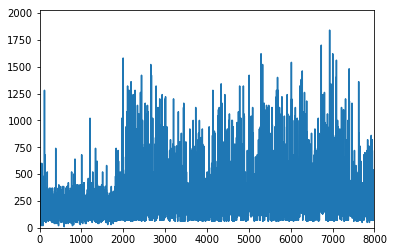

total_num_games=8000 average=276.161 moving_average=258.225 time_mins=8
Iteration: 41 / 1


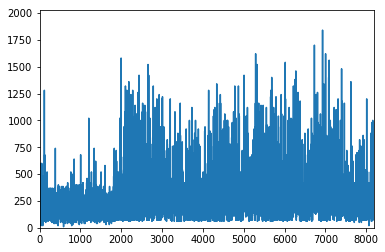

total_num_games=8200 average=276.032 moving_average=270.875 time_mins=8
Iteration: 42 / 1


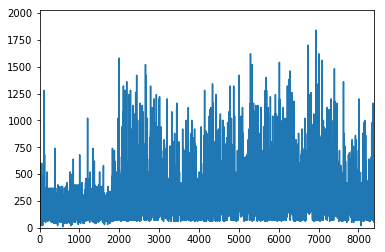

total_num_games=8400 average=275.632 moving_average=259.250 time_mins=8
Iteration: 43 / 1


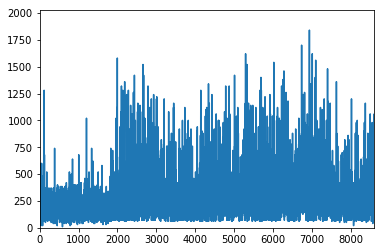

total_num_games=8600 average=275.701 moving_average=278.575 time_mins=8
Iteration: 44 / 1


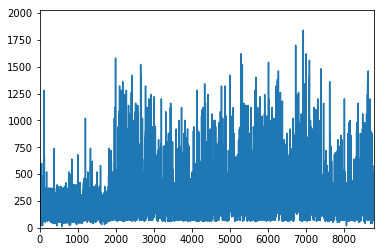

total_num_games=8800 average=275.844 moving_average=282.000 time_mins=8
Iteration: 45 / 1


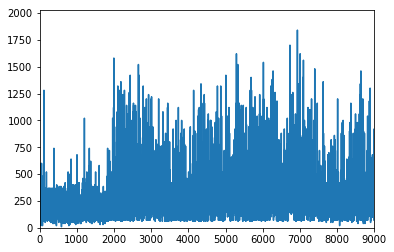

total_num_games=9000 average=276.462 moving_average=303.650 time_mins=8
Iteration: 46 / 1


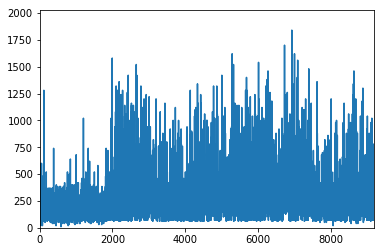

total_num_games=9200 average=276.108 moving_average=260.175 time_mins=8
Iteration: 47 / 1


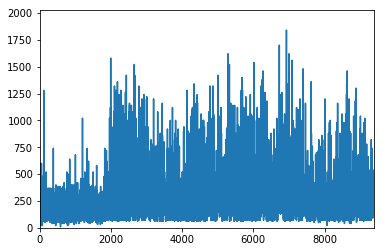

total_num_games=9400 average=276.077 moving_average=274.675 time_mins=8
Iteration: 48 / 1


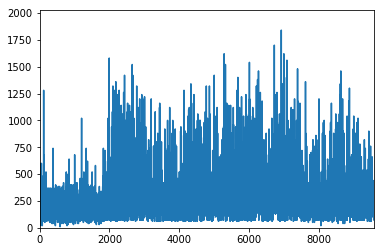

total_num_games=9600 average=275.860 moving_average=265.650 time_mins=8
Iteration: 49 / 1


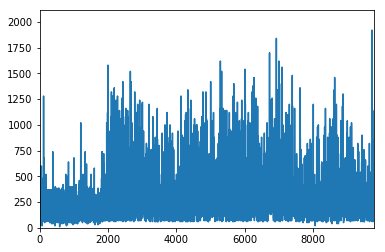

total_num_games=9800 average=275.958 moving_average=280.675 time_mins=8
Iteration: 50 / 1


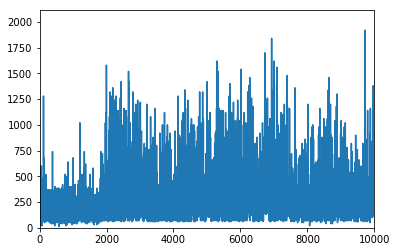

total_num_games=10000 average=276.082 moving_average=282.150 time_mins=8
Iteration: 51 / 1


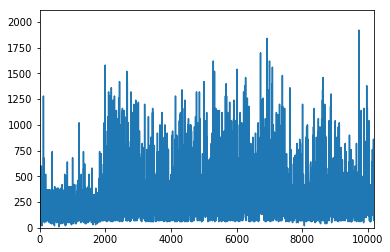

total_num_games=10200 average=276.073 moving_average=275.625 time_mins=8
Iteration: 52 / 1


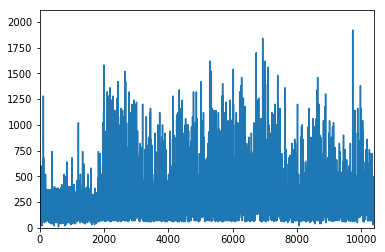

total_num_games=10400 average=275.239 moving_average=232.700 time_mins=7
Iteration: 53 / 1


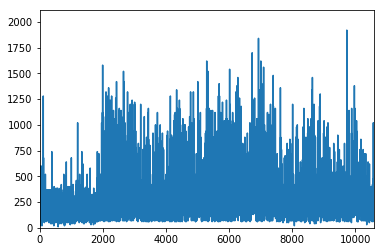

total_num_games=10600 average=274.198 moving_average=220.075 time_mins=7
Iteration: 54 / 1


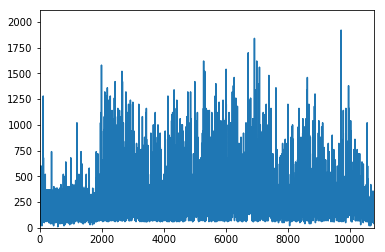

total_num_games=10800 average=271.073 moving_average=105.450 time_mins=9
Iteration: 55 / 1


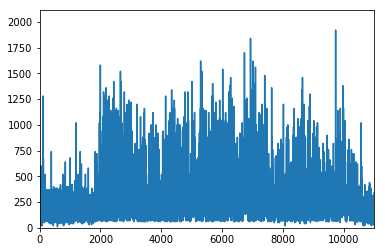

total_num_games=11000 average=268.949 moving_average=154.250 time_mins=6
Iteration: 56 / 1


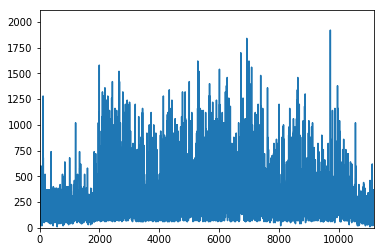

total_num_games=11200 average=266.749 moving_average=145.750 time_mins=6
Iteration: 57 / 1


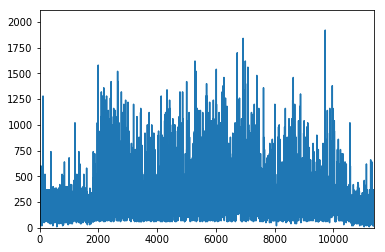

total_num_games=11400 average=264.456 moving_average=136.025 time_mins=5
Iteration: 58 / 1


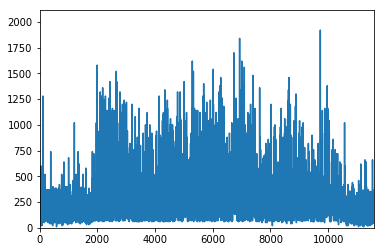

total_num_games=11600 average=262.303 moving_average=139.600 time_mins=5
Iteration: 59 / 1


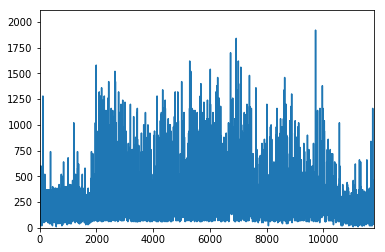

total_num_games=11800 average=260.296 moving_average=143.875 time_mins=6
Iteration: 60 / 1


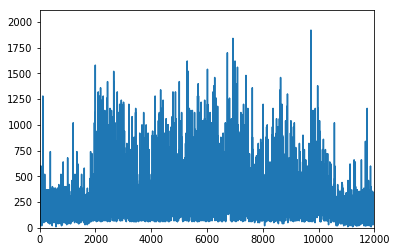

total_num_games=12000 average=258.511 moving_average=153.225 time_mins=6
Iteration: 61 / 1


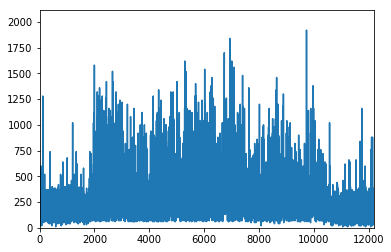

total_num_games=12200 average=256.846 moving_average=156.925 time_mins=6
Iteration: 62 / 1


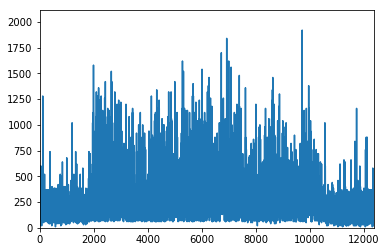

total_num_games=12400 average=255.287 moving_average=160.200 time_mins=6
Iteration: 63 / 1


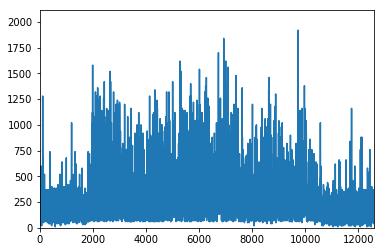

total_num_games=12600 average=253.738 moving_average=157.675 time_mins=6
Iteration: 64 / 1


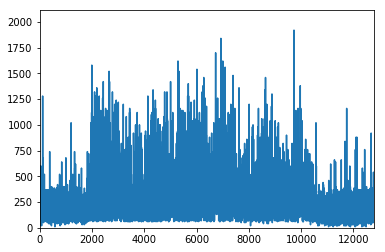

total_num_games=12800 average=252.162 moving_average=152.875 time_mins=7
Iteration: 65 / 1


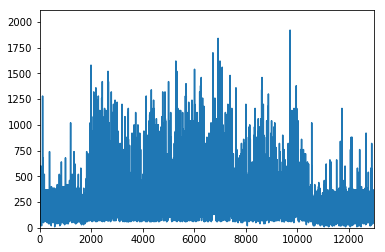

total_num_games=13000 average=250.857 moving_average=167.375 time_mins=6
Iteration: 66 / 1


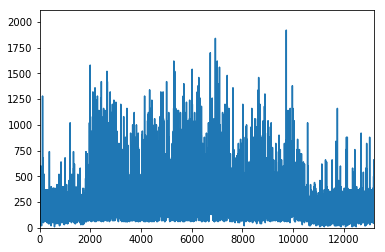

total_num_games=13200 average=249.699 moving_average=174.400 time_mins=7
Iteration: 67 / 1


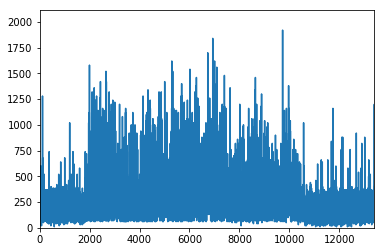

total_num_games=13400 average=248.679 moving_average=181.400 time_mins=6
Iteration: 68 / 1


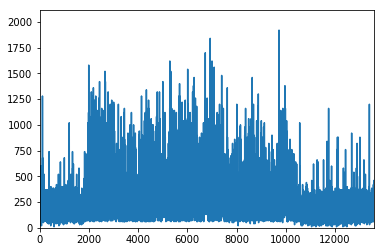

total_num_games=13600 average=247.405 moving_average=162.025 time_mins=6
Iteration: 69 / 1


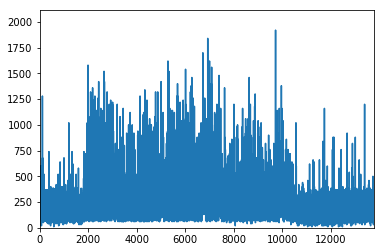

total_num_games=13800 average=246.178 moving_average=162.700 time_mins=6
Iteration: 70 / 1


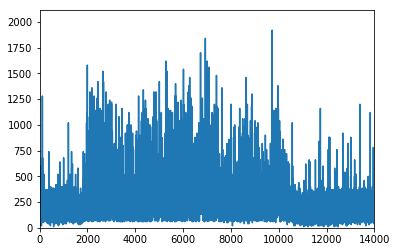

total_num_games=14000 average=245.238 moving_average=180.375 time_mins=6
Iteration: 71 / 1


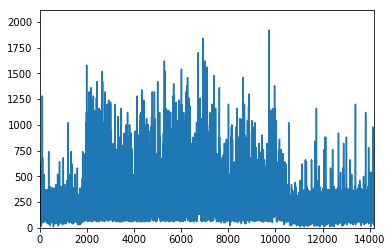

total_num_games=14200 average=244.397 moving_average=185.575 time_mins=6
Iteration: 72 / 1


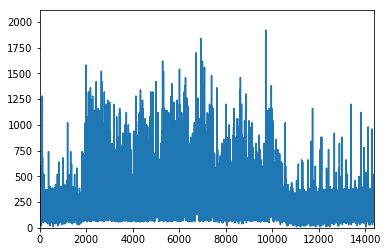

total_num_games=14400 average=243.564 moving_average=184.400 time_mins=6
Iteration: 73 / 1


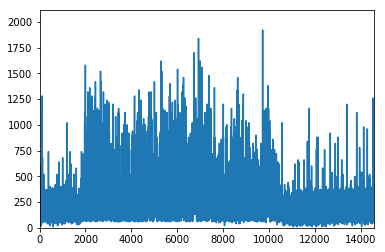

total_num_games=14600 average=242.906 moving_average=195.550 time_mins=6
Iteration: 74 / 1


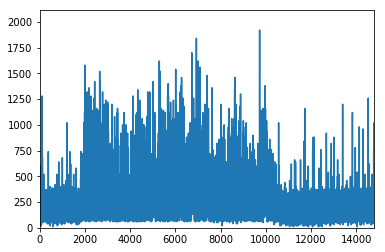

total_num_games=14800 average=242.112 moving_average=184.125 time_mins=6
Iteration: 75 / 1


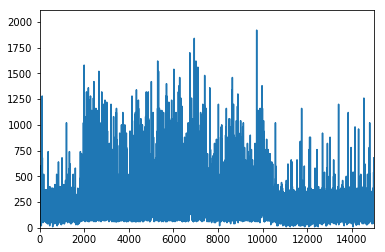

total_num_games=15000 average=241.305 moving_average=181.575 time_mins=7
Iteration: 76 / 1


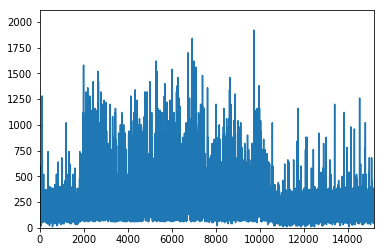

total_num_games=15200 average=240.478 moving_average=178.475 time_mins=6
Iteration: 77 / 1


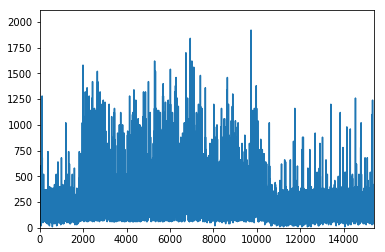

total_num_games=15400 average=239.719 moving_average=182.025 time_mins=6
Iteration: 78 / 1


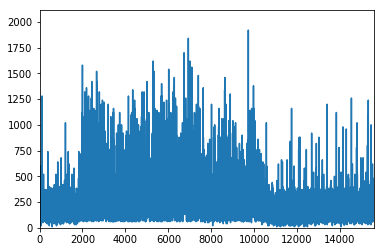

total_num_games=15600 average=239.097 moving_average=191.250 time_mins=6
Iteration: 79 / 1


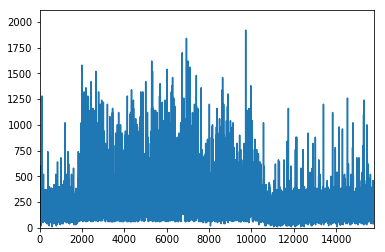

total_num_games=15800 average=238.327 moving_average=178.200 time_mins=6


In [21]:
num_iterations = 1
i = 0
need_stop = False
while(need_stop == False):
#for i in range(num_iterations):
    t1 = time.time()
    print ("Iteration:", i + 1, '/', num_iterations)
    i += 1
    red_games, commulative_rewards = red_play(num_games=num_games, max_steps=3000, render=False, V=V)
    commulative_rewards_np = np.array(commulative_rewards)
    rewards = np.hstack((rewards, commulative_rewards_np))
    x = np.linspace(1, len(rewards), len(rewards))
    plt.plot(x, rewards)
    plt.axis([0, x.size, 0, 1.1 * rewards.max()])
    plt.show()
    red_train_agent2(1, red_games, commulative_rewards_np)
    print("total_num_games=%d average=%.3f moving_average=%.3f time_mins=%d" %
          (x.size, rewards.mean(), rewards[-num_games:].mean(), (time.time() - t1) / 60 ))
    with open("/home/martin/1.ctl") as f:
        cmd = f.readline()
        if cmd.find("RUN") < 0:
            need_stop = True

In [22]:
g, r = red_play(num_games=1, max_steps=5000, render=True, V=V)

In [ ]:
sess.run(red_W)

In [ ]:
def onehot2int(v):
    for _ in range(len(v)):
        if v[_] == 1:
            return _
    return len(v)

In [ ]:
actions = deque()
onehot2int(red_games[0][0][1])
actions = deque()
for game in games:
    for step in game:
        actions.append(onehot2int(step[1]))

In [ ]:
print (len(actions))

In [ ]:
h = np.histogram(actions, bins=6)
plt.plot(h[1][1:], h[0])
plt.show()
print (h, np.sum(h[0]))

In [ ]:
def save_model(directory):
    saver = tf.train.Saver()
    saver.save(sess, directory)
    np.save(directory + "/rewards", rewards)
    np.save(directory + "/V-matrix", V)

In [ ]:
save_model("/home/martin/reinforcement_learning_runs/1/")

In [ ]:
saver.restore(sess=sess, save_path="/home/martin/notebooks/checkpoints/OpenAI-DemonAttack-v3-a7")